# Air Quality Data analysis

Here, I have plotted and analysed the satellite-derived PM2.5 data for India. The data has a resolution of $0.1\degree \times 0.1\degree$. The dataset that I have used is provided by the [Atmospheric Composition Analysis Group](https://sites.wustl.edu/acag/datasets/surface-pm2-5/) and 
is available here: https://wustl.app.box.com/v/ACAG-V5GL04-GWRPM25c0p10/folder/237168822060

#### Import Libraries

In [2]:
%matplotlib tk

import numpy as np
import netCDF4
import reverse_geocode
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from joblib import Parallel, delayed 

#### Constants

In [3]:
Timestamp_Start = 1998 * 12
Timepoints = 300
Timestamp_End = Timestamp_Start + Timepoints

#### Functions

In [25]:
def getYearMonth(timestamp):
  return int(timestamp / 12), (timestamp % 12 + 1)

def getAsiaPM25Filename(timestamp):
  year, month = getYearMonth(timestamp)
  month = str(month).zfill(2)
  return f'monthly/V5GL04.HybridPM25c_0p10.Asia.{year}{month}-{year}{month}.nc'

def getIndiaPM25Filename(timestamp):
  year, month = getYearMonth(timestamp)
  month = str(month).zfill(2)
  return f'formatted_monthly/PM2.5_India.{year}{month}.nc'

def getAsiaPM25Data(timestamp):
  fileName = getAsiaPM25Filename(timestamp)
  # print(fileName)
  ncFile = netCDF4.Dataset(fileName)
  data = np.array(ncFile.variables['lat']), np.array(ncFile.variables['lon']), ncFile.variables["GWRPM25"][:, :]
  ncFile.close()
  return data

def getIndiaPM25Data(timestamp):
  fileName = getIndiaPM25Filename(timestamp)
  ncFile = netCDF4.Dataset(fileName)
  data = np.array(ncFile.variables['lat']), np.array(ncFile.variables['lon']), (ncFile.variables['GWRPM25'])
  ncFile.close()
  return data

## Preparing the dataset

While the provided data encompasses all of Asia, here I'm specifically extracting information relevant to India.  I use the `reverse_geocode` library to check if a given cell lies in India after trimming the dataset. However, this still takes a lot of time to compute, so I have saved all the data in the `formatted_monthly` directory. 

In [36]:
# This will return the lat and lon of the initial coordintes
def getAsiaLatLon():
    data = getAsiaPM25Data(Timestamp_Start)
    return data[0], data[1]

lat, lon = getAsiaLatLon()

lat_mask = (lat > 8.06666667) & (lat < 37.1) # latitude of India
lon_mask = (lon > 68.1166667) & (lon < 97.4166667) # longitude of India

lat = lat[lat_mask]
lon = lon[lon_mask]

def readAndFormatData(fileIdx):
    data = getAsiaPM25Data(fileIdx + Timestamp_Start)[2][lat_mask, :][:, lon_mask]
    for i, _lat in enumerate(lat):
        for j, _lon in enumerate(lon):
            coords = (_lat, _lon),
            obj = reverse_geocode.search(coords)
            if obj[0]['country'] != 'India':
                data[i][j] = np.nan

    return data

def saveDataToFile(timestamp, pm25):
    ncfile = netCDF4.Dataset(getIndiaPM25Filename(timestamp), mode='w', format='NETCDF4_CLASSIC')
    
    lat_dim = ncfile.createDimension('lat', len(lat))     # latitude axis
    lon_dim = ncfile.createDimension('lon', len(lon))    # longitude axis
    
    lat_var = ncfile.createVariable('lat', np.float64, ('lat',))
    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var = ncfile.createVariable('lon', np.float64, ('lon',))
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'
    
    GWRPM25 = ncfile.createVariable('GWRPM25', np.float32, ('lat','lon')) 
    
    lat_var[:] = lat
    lon_var[:] = lon
    GWRPM25[:,:] = pm25
    
    ncfile.close()

def formatFile(fileNumber):
    print(f"Writing file {fileNumber}")
    saveDataToFile(fileNumber + Timestamp_Start, readAndFormatData(fileNumber))
    
Parallel(n_jobs=-1)(delayed(formatFile) (i) for i in range(Timepoints)) 

print("Done!")

Done!


## Video Animation of the Air quality snapshots
Here is a video animation of the air quality snapshots of India over the time period of 1998-2022. Here, I have used the non-formatted data. However, to use the formatted data, you can change the directory of the variable `fp` from `monthly` to `monthly_formatted` at the two places.

In [48]:
scale = 1/40
frames = 300
interval = 100

lat, lon, data = getAsiaPM25Data(Timestamp_Start)

lat = np.round(lat, 2)
lon = np.round(lon, 2)

lat_mask = (lat > 8.06666667) & (lat < 37.1) # latitude of india
lon_mask = (lon > 68.1166667) & (lon < 97.4166667) # longitude of india

lat_step_size = 50
lon_step_size = 50

lat = lat[lat_mask]
lon = lon[lon_mask]
data = data[lat_mask, :][:, lon_mask]

fig = plt.figure(figsize=(data.shape[0]*scale, data.shape[1]*scale))
im = plt.imshow(data, vmin=0, vmax=200)

plt.ylim(bottom=0, top=len(data))
plt.yticks(np.arange(0, data.shape[0], lat_step_size), labels=lat[::lat_step_size])
plt.xticks(np.arange(0, data.shape[1], lon_step_size), labels=lon[::lon_step_size], rotation=45)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title(f"PM2.5 Monthly Mean [ug/m3]: Year {1998} Month {1}", fontsize=16)
plt.colorbar()
plt.tight_layout()

def animation_fn(frame):
    year, month = getYearMonth(Timestamp_Start + frame)
    im.set_array(getAsiaPM25Data(frame + Timestamp_Start)[2][lat_mask, :][:,  lon_mask])
    im.axes.set_title(f"PM2.5 Monthly Mean [ug/m3]: Year {year} Month {int(month)}", fontsize=16)
    
    return [im]

anim = animation.FuncAnimation(fig, animation_fn, frames=frames, interval=interval)
plt.show()

## Monthly Average PM2.5 in India
The graph below shows the monthly average PM2.5 in India. It has a periodic nature.

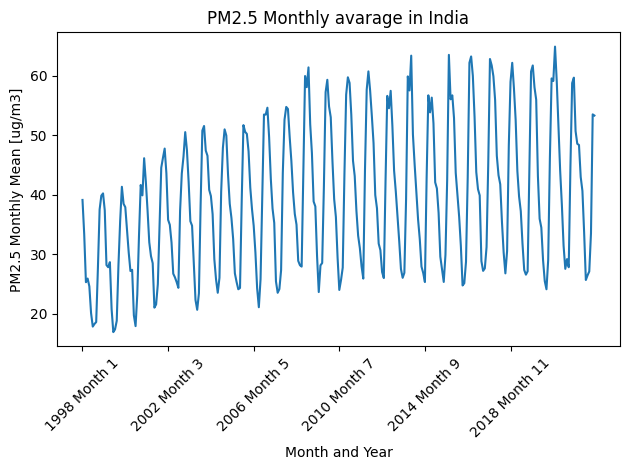

In [5]:
# Average of India for all the months
from matplotlib import pyplot as plt
import netCDF4
import numpy as np

step_size = 50
monthly_average = []
num_years = 25

for i in range(300):
    fp=f"formatted_monthly/{i}.nc"
    nc = netCDF4.Dataset(fp)
    avg = np.nanmean(nc.variables["GWRPM25"])
    monthly_average.append(avg)

def get_label_string(frame):
    return f"{1998 + int(frame/12)} Month {frame % 12 + 1}"

plt.plot(monthly_average)
plt.xticks(np.arange(0, num_years * 12, step_size), labels=[get_label_string(frame) for frame in range(0, num_years * 12, step_size)], rotation=45)
plt.title("PM2.5 Monthly avarage in India")
plt.ylabel("PM2.5 Monthly Mean [ug/m3]")
plt.xlabel("Month and Year")
plt.tight_layout()
plt.show()

## Yearly average PM2.5 in India
As you can see from below the yearly PM2.5 average.

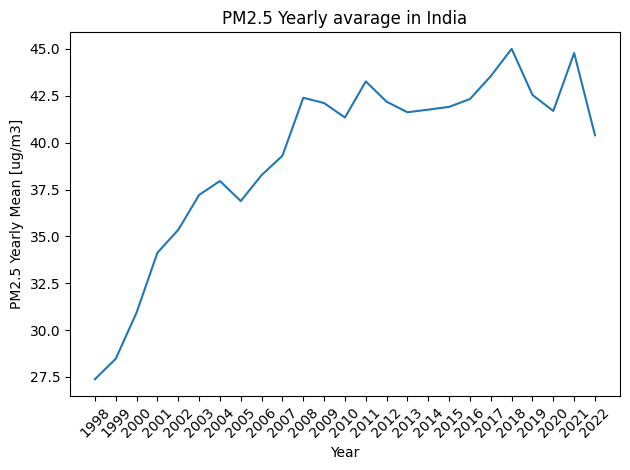

In [12]:
from matplotlib import pyplot as plt
import numpy as np

step_size = 1
yearly_average = [np.mean(monthly_average[i:i+12]) for i in range(0, num_years * 12, 12)]
plt.plot(yearly_average)
plt.xticks(np.arange(0, len(yearly_average), step_size), labels=[f"{1998 + frame}" for frame in range(0, len(yearly_average), step_size)], rotation=45)
plt.title("PM2.5 Yearly avarage in India")
plt.ylabel("PM2.5 Yearly Mean [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Monthly average over the years
As you can see from the plot below the PM2.5 data is at the minimum in around Augest and reaches the maximum in around January and December 

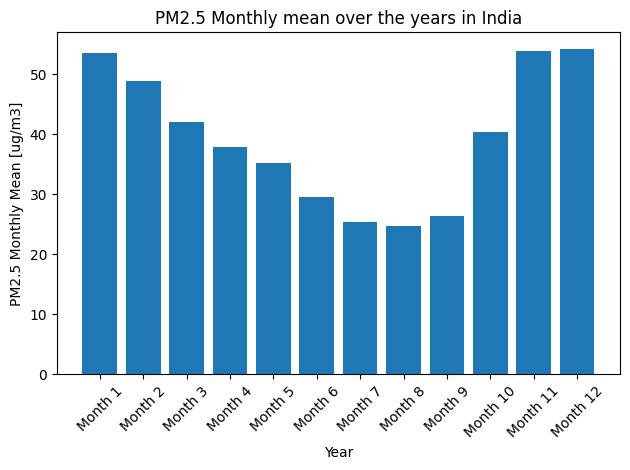

In [11]:
import numpy as np
from matplotlib import pyplot as plt

monthly_av_over_years = [np.mean(monthly_average[i::12]) for i in range(12)]
plt.bar([f"Month {frame + 1}" for frame in range(0, 12)], monthly_av_over_years)
plt.xticks(np.arange(0, 12, step_size), rotation=45)
plt.title("PM2.5 Monthly mean over the years in India")
plt.ylabel("PM2.5 Monthly Mean [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Yearly Standard deviation of PM2.5 in India

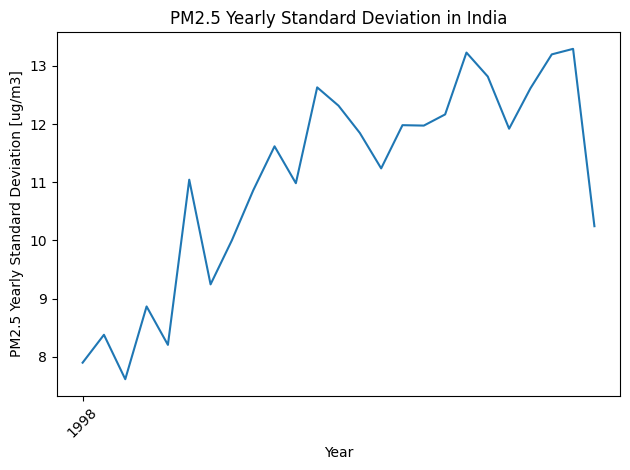

In [6]:
import numpy as np
from matplotlib import pyplot as plt

num_years = 25
yearly_sd = [np.std(monthly_average[i:i+12]) for i in range(0, num_years * 12, 12)]
plt.figure()
plt.plot(yearly_sd)
plt.xticks(np.arange(0, num_years, step_size), labels=[f"{1998 + frame}" for frame in range(0, num_years, step_size)], rotation=45)
plt.title("PM2.5 Yearly Standard Deviation in India")
plt.ylabel("PM2.5 Yearly Standard Deviation [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Predicting PM2.5 with time using Regression

### Linear Regression
Here I have performed a regression over the monthly snapshot of India. However this doesn't give good results, because of the periodic nature of PM2.5 in India. Hence I have also performed a regression for each month seperatly.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

step_size = 50

def print_error(err):
    df = pd.DataFrame([[f'Year {int(i/12) + 1998}, Month {i % 12 + 1}', elt] for i, elt in enumerate(err)], columns=["Time", "Error"])
    print(df.to_markdown())

def plot_error(err, title, ylabel):
    plt.figure()
    plt.plot(err)
    plt.xticks(np.arange(0, len(err), step_size), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(err), step_size)], rotation=45)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Year and Month")
    plt.tight_layout()
    plt.show()

In [51]:
from sklearn.linear_model import LinearRegression
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]

error_linear_regression = np.zeros(300)
cnt = 0
def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    cnt += 1
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data) * 0.2)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_linear_regression
    error_linear_regression += ((predictions - current_data[:, 1]) ** 2)
    
Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_linear_regression /= cnt
error_linear_regression = np.sqrt(error_linear_regression)
print_error(error_linear_regression)

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  | 18.8846  |
|   1 | Year 1998, Month 2  | 10.4662  |
|   2 | Year 1998, Month 3  |  7.46604 |
|   3 | Year 1998, Month 4  |  6.3853  |
|   4 | Year 1998, Month 5  |  6.39752 |
|   5 | Year 1998, Month 6  | 11.486   |
|   6 | Year 1998, Month 7  | 13.8018  |
|   7 | Year 1998, Month 8  | 13.9136  |
|   8 | Year 1998, Month 9  | 13.7579  |
|   9 | Year 1998, Month 10 |  7.33568 |
|  10 | Year 1998, Month 11 | 18.3435  |
|  11 | Year 1998, Month 12 | 22.3858  |
|  12 | Year 1999, Month 1  | 19.7591  |
|  13 | Year 1999, Month 2  | 14.4864  |
|  14 | Year 1999, Month 3  | 11.937   |
|  15 | Year 1999, Month 4  |  7.47221 |
|  16 | Year 1999, Month 5  |  8.77492 |
|  17 | Year 1999, Month 6  | 13.7959  |
|  18 | Year 1999, Month 7  | 15.9227  |
|  19 | Year 1999, Month 8  | 16.0719  |
|  20 | Year 1999, Month 9  | 15.0139  |
|  21 | Year 1999, Month 10 |  8.76216 |
|  22 | Year 199

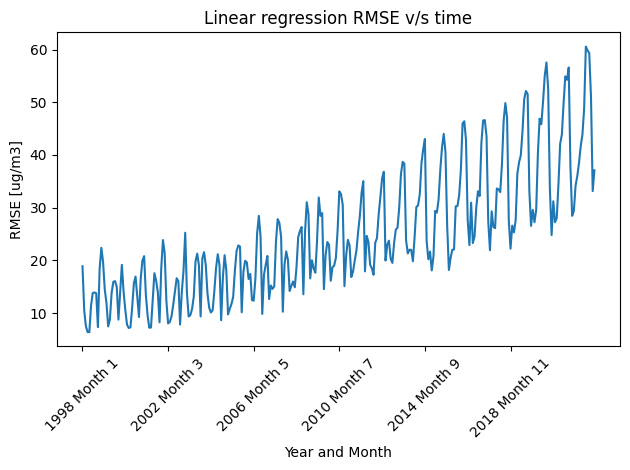

In [52]:
plot_error(error_linear_regression, "Linear regression RMSE v/s time", "RMSE [ug/m3]")

### Linear Regression (Monthly)
Since PM2.5 in India is somewhat periodic, I though of sampling data from each month for a region and then doing linear regression on that, the results come out to be better than the normal Linear Regression, However I had to train on 50% of the data. Here rergession is done only on top $12\degree$ latitudes of India.

In [53]:
from sklearn.linear_model import LinearRegression
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
error_linear_regression_monthly = np.zeros(300)
cnt = 0

max_lat = 100

# 346188
def train_and_compute_error(month, i, j):
    if np.isnan(all_data[month, i, j]):
        return
    global cnt
    cnt += 1
    unshuffled_data = (np.array(list(enumerate(all_data[month::12, i, j]))))
    current_data = (np.array(list(enumerate(all_data[month::12, i, j]))))
    training_data_length = int(len(current_data) * 0.5)
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_linear_regression_monthly
    for i, e in enumerate(((predictions - unshuffled_data[:, 1]) ** 2)):
        error_linear_regression_monthly[12 * i + month] += e

# Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(month, i, j) for i in range(len(lat)) for j in range(len(lon)) for month in range(12))
Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(month, i, j) for i in range(max_lat) for j in range(len(lon)) for month in range(12))
error_linear_regression_monthly /= cnt/12
error_linear_regression_monthly = np.sqrt(error_linear_regression_monthly)
print_error(error_linear_regression_monthly)

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  |  7.30463 |
|   1 | Year 1998, Month 2  |  7.70297 |
|   2 | Year 1998, Month 3  |  9.39387 |
|   3 | Year 1998, Month 4  |  7.19716 |
|   4 | Year 1998, Month 5  |  4.02424 |
|   5 | Year 1998, Month 6  |  2.72531 |
|   6 | Year 1998, Month 7  |  3.19412 |
|   7 | Year 1998, Month 8  |  3.43827 |
|   8 | Year 1998, Month 9  |  4.79356 |
|   9 | Year 1998, Month 10 |  8.03379 |
|  10 | Year 1998, Month 11 |  9.35237 |
|  11 | Year 1998, Month 12 |  5.29437 |
|  12 | Year 1999, Month 1  |  4.63903 |
|  13 | Year 1999, Month 2  |  5.57666 |
|  14 | Year 1999, Month 3  |  5.14332 |
|  15 | Year 1999, Month 4  |  5.71006 |
|  16 | Year 1999, Month 5  |  3.67547 |
|  17 | Year 1999, Month 6  |  2.94355 |
|  18 | Year 1999, Month 7  |  4.54508 |
|  19 | Year 1999, Month 8  |  3.96806 |
|  20 | Year 1999, Month 9  |  5.36793 |
|  21 | Year 1999, Month 10 |  9.4555  |
|  22 | Year 199

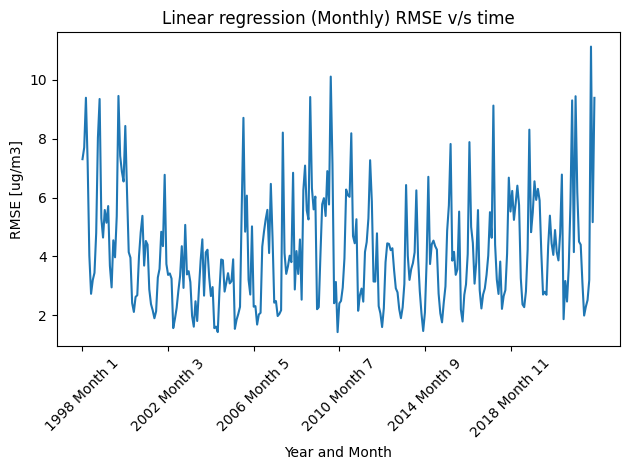

In [54]:
plot_error(error_linear_regression_monthly, "Linear regression (Monthly) RMSE v/s time", "RMSE [ug/m3]")

### Random Forest
Here I try to predict PM2.5 using the Random Forest Algorithm. I have done regression only on 500 grids of India of area $0.1\degree \times 0.1\degree$

In [55]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
error_random_forest = np.zeros(300)
cnt = 0

max_grids = 500

def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    if cnt > max_grids:
        return
    cnt += 1
    unshuffled_data = (np.array(list(enumerate(all_data[:, i, j]))))
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data))
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    reg = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=0).fit(X, current_data[:training_data_length, 1])
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_random_forest
    error_random_forest += ((predictions - unshuffled_data[:, 1]) ** 2)

Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_random_forest /= cnt
error_random_forest = np.sqrt(error_random_forest)
print_error(error_random_forest)

|     | Time                |     Error |
|----:|:--------------------|----------:|
|   0 | Year 1998, Month 1  |  1.57045  |
|   1 | Year 1998, Month 2  |  2.09854  |
|   2 | Year 1998, Month 3  |  1.5508   |
|   3 | Year 1998, Month 4  |  2.68953  |
|   4 | Year 1998, Month 5  |  1.12141  |
|   5 | Year 1998, Month 6  |  1.30646  |
|   6 | Year 1998, Month 7  |  0.498576 |
|   7 | Year 1998, Month 8  |  0.605861 |
|   8 | Year 1998, Month 9  |  0.903587 |
|   9 | Year 1998, Month 10 |  1.55038  |
|  10 | Year 1998, Month 11 |  1.7602   |
|  11 | Year 1998, Month 12 |  2.19203  |
|  12 | Year 1999, Month 1  |  3.16138  |
|  13 | Year 1999, Month 2  |  1.94765  |
|  14 | Year 1999, Month 3  |  1.82008  |
|  15 | Year 1999, Month 4  |  2.31101  |
|  16 | Year 1999, Month 5  |  2.6327   |
|  17 | Year 1999, Month 6  |  1.50052  |
|  18 | Year 1999, Month 7  |  0.764445 |
|  19 | Year 1999, Month 8  |  0.697819 |
|  20 | Year 1999, Month 9  |  1.2097   |
|  21 | Year 1999, Month 10 |  2.2

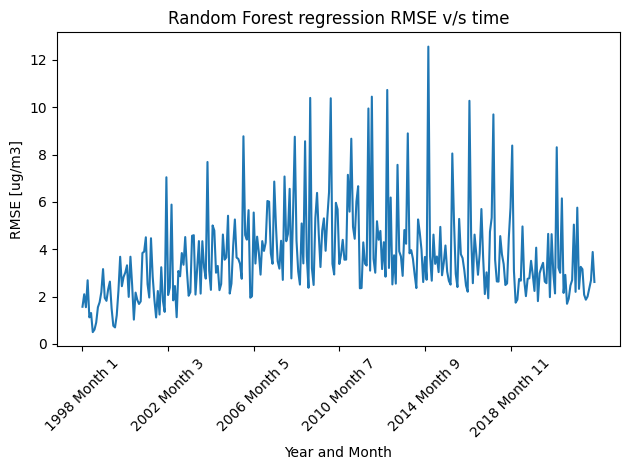

In [56]:
plot_error(error_random_forest, "Random Forest regression RMSE v/s time", "RMSE [ug/m3]")

### K nearest neighbors

In [58]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]

error_knn = np.zeros(300)
cnt = 0
def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    cnt += 1
    # if cnt > max_grids:
    #     return
    unshuffled_data = (np.array(list(enumerate(all_data[:, i, j]))))
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data) * 0.2)
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = KNeighborsRegressor(n_neighbors=2).fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_knn
    error_knn += ((predictions - unshuffled_data[:, 1]) ** 2)

Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_knn /= cnt
error_knn = np.sqrt(error_knn)
print_error(error_knn)

|     | Time                |   Error |
|----:|:--------------------|--------:|
|   0 | Year 1998, Month 1  | 19.7137 |
|   1 | Year 1998, Month 2  | 13.1014 |
|   2 | Year 1998, Month 3  | 11.7324 |
|   3 | Year 1998, Month 4  | 10.6554 |
|   4 | Year 1998, Month 5  | 10.594  |
|   5 | Year 1998, Month 6  | 13.1368 |
|   6 | Year 1998, Month 7  | 15.0099 |
|   7 | Year 1998, Month 8  | 15.6987 |
|   8 | Year 1998, Month 9  | 16.521  |
|   9 | Year 1998, Month 10 | 11.8068 |
|  10 | Year 1998, Month 11 | 19.3206 |
|  11 | Year 1998, Month 12 | 22.6129 |
|  12 | Year 1999, Month 1  | 20.4177 |
|  13 | Year 1999, Month 2  | 16.8956 |
|  14 | Year 1999, Month 3  | 15.4441 |
|  15 | Year 1999, Month 4  | 11.9933 |
|  16 | Year 1999, Month 5  | 12.6046 |
|  17 | Year 1999, Month 6  | 15.1333 |
|  18 | Year 1999, Month 7  | 16.5036 |
|  19 | Year 1999, Month 8  | 16.8843 |
|  20 | Year 1999, Month 9  | 16.4464 |
|  21 | Year 1999, Month 10 | 12.4744 |
|  22 | Year 1999, Month 11 | 16.3501 |


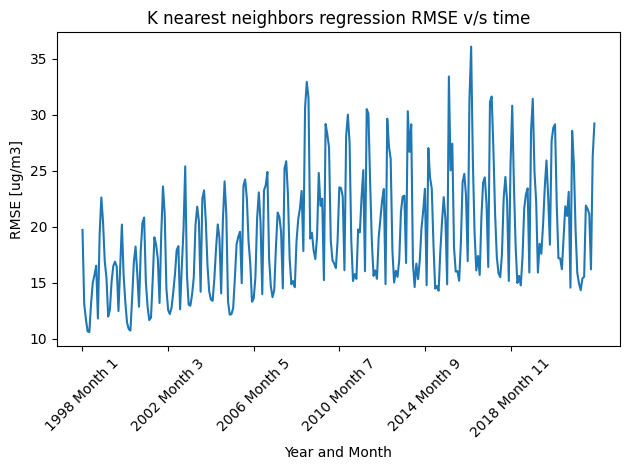

In [59]:
plot_error(error_knn, "K nearest neighbors regression RMSE v/s time", "RMSE [ug/m3]")

### Final Results - Comparing various algorithms

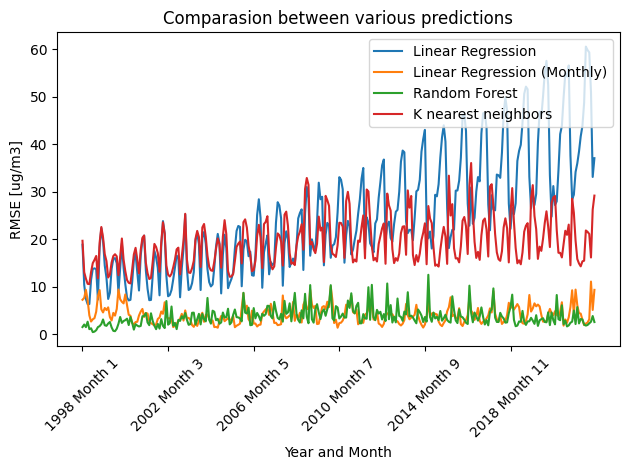

In [61]:
plt.figure()
[lr, lrm, rf, knn] = plt.plot(np.transpose([error_linear_regression, error_linear_regression_monthly, error_random_forest, error_knn]))
plt.legend([lr, lrm, rf, knn], ["Linear Regression", "Linear Regression (Monthly)", "Random Forest", "K nearest neighbors"], loc=1)
plt.xticks(np.arange(0, len(error_linear_regression), step_size), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(error_linear_regression), step_size)], rotation=45)
plt.title("Comparasion between various algorithms")
plt.ylabel("RMSE [ug/m3]")
plt.xlabel("Year and Month")
plt.tight_layout()
plt.show()

## Predicting spatial PM2.5 using Regression

### Linear regerssion

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]
error_linear_regression = np.zeros(300)
n_months = 12
step_size = 1

def train_and_compute_error(frame):
    current_data = np.array([[_lat, _lon, all_data[frame, i, j]] for i, _lat in enumerate(lat) for j, _lon in enumerate(lon)])
    current_data = current_data[~np.isnan(current_data[:, 2])]
    training_data_length = int(len(current_data) * 0.4)
    # Randomly pick training_data_length points from current_data
    training_data = current_data[np.random.choice(len(current_data), training_data_length)]
    X = training_data[:, :2]
    y = training_data[:, 2]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict(current_data[:, :2])
    print(reg.coef_, predictions)
    return np.sqrt(np.mean((predictions - current_data[:, 2]) ** 2))
    
for i in range(n_months):
    error_linear_regression[i] = train_and_compute_error(i)
# for i, error in enumerate(Parallel(n_jobs=-1, require='sharedmem')(delayed(train_and_compute_error)(i) for i in range(4))):
#     pass
# #     # if i % 5:
# #     print(i)
#     error_linear_regression[i] = error

[1.20290398 0.01639493] [21.09239507 21.09403456 21.09567405 ... 55.24667058 55.24831008
 55.24994957]
[0.47081376 0.05794503] [26.32105537 26.32684988 26.33264438 ... 39.66319367 39.66898817
 39.67478267]
[0.21224649 0.00951169] [22.06944262 22.07039379 22.07134496 ... 28.09248713 28.0934383
 28.09438947]
[ 0.880745  -0.2684635] [13.65899107 13.63214472 13.60529837 ... 38.80638074 38.77953439
 38.75268804]
[ 1.1033502  -0.57653858] [ 9.76060615  9.7029523   9.64529844 ... 41.38402104 41.32636718
 41.26871332]
[ 0.81484092 -0.75140422] [10.1469312  10.07179078  9.99665036 ... 33.66411541 33.58897499
 33.51383457]
[ 0.5888446  -0.72577659] [11.09895509 11.02637743 10.95379977 ... 28.18503002 28.11245236
 28.0398747 ]
[ 0.52287056 -0.74612346] [12.59933271 12.52472036 12.45010802 ... 27.82191844 27.7473061
 27.67269375]
[ 0.32064266 -0.48227253] [15.07178095 15.0235537  14.97532645 ... 24.4191687  24.37094144
 24.32271419]
[ 1.09659719 -0.71768524] [13.29466902 13.22290049 13.15113197 ..

|    | Time                |    Error |
|---:|:--------------------|---------:|
|  0 | Year 1998, Month 1  | 23.2441  |
|  1 | Year 1998, Month 2  | 16.6367  |
|  2 | Year 1998, Month 3  | 10.9308  |
|  3 | Year 1998, Month 4  | 13.6496  |
|  4 | Year 1998, Month 5  | 13.087   |
|  5 | Year 1998, Month 6  | 11.431   |
|  6 | Year 1998, Month 7  |  8.995   |
|  7 | Year 1998, Month 8  |  9.63601 |
|  8 | Year 1998, Month 9  |  8.35689 |
|  9 | Year 1998, Month 10 | 15.3261  |
| 10 | Year 1998, Month 11 | 25.4176  |
| 11 | Year 1998, Month 12 | 28.3874  |


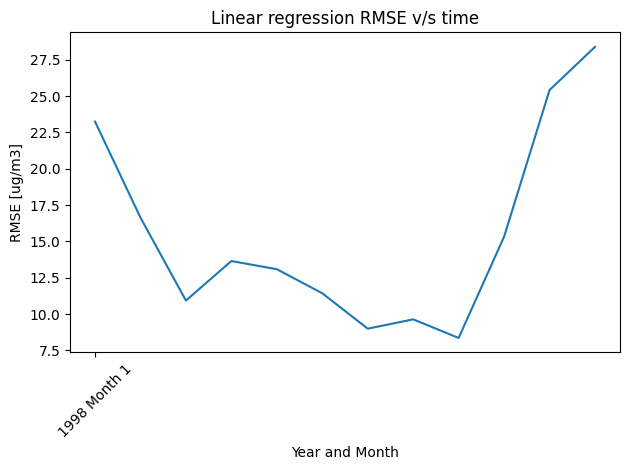

In [4]:
print_error(error_linear_regression[:n_months])
plot_error(error_linear_regression[:n_months], "Linear regression RMSE v/s time", "RMSE [ug/m3]")

### Random forest

|    | Time                |    Error |
|---:|:--------------------|---------:|
|  0 | Year 1998, Month 1  |  8.44671 |
|  1 | Year 1998, Month 2  |  6.71008 |
|  2 | Year 1998, Month 3  |  5.5441  |
|  3 | Year 1998, Month 4  |  5.62306 |
|  4 | Year 1998, Month 5  |  5.162   |
|  5 | Year 1998, Month 6  |  3.85407 |
|  6 | Year 1998, Month 7  |  3.00987 |
|  7 | Year 1998, Month 8  |  3.04731 |
|  8 | Year 1998, Month 9  |  3.31695 |
|  9 | Year 1998, Month 10 |  5.58974 |
| 10 | Year 1998, Month 11 |  8.81536 |
| 11 | Year 1998, Month 12 | 10.6881  |


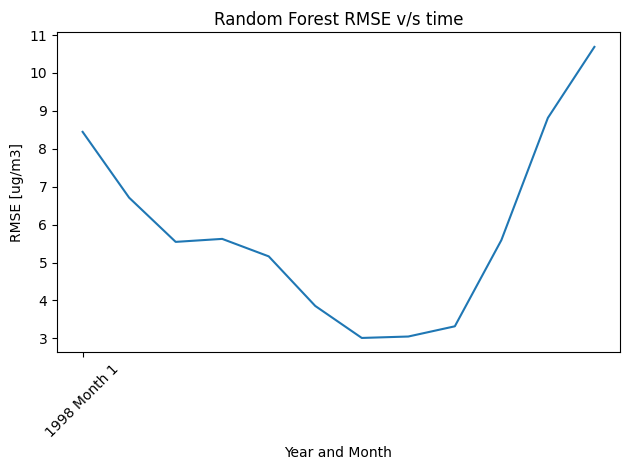

In [5]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]
error_random_forest = np.zeros(300)
n_months = 12

def train_and_compute_error(frame):
    current_data = np.array([[_lat, _lon, all_data[frame, i, j]] for i, _lat in enumerate(lat) for j, _lon in enumerate(lon)])
    current_data = current_data[~np.isnan(current_data[:, 2])]
    training_data_length = int(len(current_data))
    # Randomly pick training_data_length points from current_data
    training_data = current_data[np.random.choice(len(current_data), training_data_length)]
    X = training_data[:, :2]
    y = training_data[:, 2]
    reg = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=0).fit(X, y)
    predictions = reg.predict(current_data[:, :2])

    return np.sqrt(np.mean((predictions - current_data[:, 2]) ** 2))
    
for i in range(n_months):
    error_random_forest[i] = train_and_compute_error(i)
# for i, error in enumerate(Parallel(n_jobs=-1, require='sharedmem')(delayed(train_and_compute_error)(i) for i in range(4))):
#     pass
# #     # if i % 5:
# #     print(i)
#     error_random_forest[i] = error
print_error(error_random_forest[:n_months])
plot_error(error_random_forest[:n_months], "Random Forest RMSE v/s time", "RMSE [ug/m3]")

### K Nearest Neighbours

|    | Time                |   Error |
|---:|:--------------------|--------:|
|  0 | Year 1998, Month 1  | 3.91335 |
|  1 | Year 1998, Month 2  | 3.57751 |
|  2 | Year 1998, Month 3  | 2.99136 |
|  3 | Year 1998, Month 4  | 2.63817 |
|  4 | Year 1998, Month 5  | 2.4778  |
|  5 | Year 1998, Month 6  | 1.79728 |
|  6 | Year 1998, Month 7  | 1.26385 |
|  7 | Year 1998, Month 8  | 1.35442 |
|  8 | Year 1998, Month 9  | 1.66434 |
|  9 | Year 1998, Month 10 | 2.7066  |
| 10 | Year 1998, Month 11 | 3.70356 |
| 11 | Year 1998, Month 12 | 5.39542 |


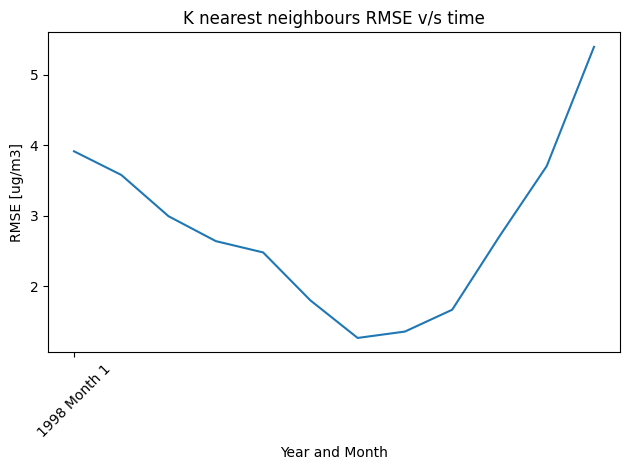

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]
error_knn = np.zeros(300)
n_months = 12

def train_and_compute_error(frame):
    current_data = np.array([[_lat, _lon, all_data[frame, i, j]] for i, _lat in enumerate(lat) for j, _lon in enumerate(lon)])
    current_data = current_data[~np.isnan(current_data[:, 2])]
    training_data_length = int(len(current_data) * 0.2)
    # Randomly pick training_data_length points from current_data
    training_data = current_data[np.random.choice(len(current_data), training_data_length)]
    X = training_data[:, :2]
    y = training_data[:, 2]
    reg = KNeighborsRegressor(n_neighbors=8).fit(X, y)
    predictions = reg.predict(current_data[:, :2])

    return np.sqrt(np.mean((predictions - current_data[:, 2]) ** 2))
    
for i in range(n_months):
    error_knn[i] = train_and_compute_error(i)
# for i, error in enumerate(Parallel(n_jobs=-1, require='sharedmem')(delayed(train_and_compute_error)(i) for i in range(4))):
#     pass
# #     # if i % 5:
# #     print(i)
#     error_knn[i] = error
print_error(error_knn[:n_months])
plot_error(error_knn[:n_months], "K nearest neighbours RMSE v/s time", "RMSE [ug/m3]")

### Final Comparasions

In [1]:
plt.figure()
[lr, rf, knn] = plt.plot(np.transpose([error_linear_regression[:n_months], error_random_forest[:n_months], error_knn[:n_months]]))
plt.legend([lr, rf, knn], ["Linear Regression",  "Random Forest", "K nearest neighbors"], loc=1)
plt.xticks(np.arange(0, len(error_linear_regression[:n_months]), step_size), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(error_linear_regression[:n_months]), step_size)], rotation=45)
plt.title("Comparasion between various algorithms")
plt.ylabel("RMSE [ug/m3]")
plt.xlabel("Year and Month")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## References
1. Atmospheric Composition Analysis Group: https://sites.wustl.edu/acag/datasets/surface-pm2-5
2. Dataset: https://wustl.app.box.com/v/ACAG-V5GL04-GWRPM25c0p10/folder/237168822060
3. reverse_geocode: https://pypi.org/project/reverse-geocode/